# Chapter 3 - Linear Regression Laboratory

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline
plt.style.use('seaborn-white')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [10]:
# temp fix from https://nbviewer.jupyter.org/gist/thatneat/10286720
def transform_exog_to_model(fit, exog):
    transform=True
    self=fit

    # The following is lifted straight from statsmodels.base.model.Results.predict()
    if transform and hasattr(self.model, 'formula') and exog is not None:
        from patsy import dmatrix
        exog = dmatrix(self.model.data.orig_exog.design_info.builder,
                       exog)

    if exog is not None:
        exog = np.asarray(exog)
        if exog.ndim == 1 and (self.model.exog.ndim == 1 or
                               self.model.exog.shape[1] == 1):
            exog = exog[:, None]
        exog = np.atleast_2d(exog)  # needed in count model shape[1]

    # end lifted code
    return exog

## Simple Linear Regression

The `ISLR2` contains the `Boston`  data set, which records `medv` (median house value) for $506$ census tracts in Boston. We will seek to predict `medv` using $12$ predictors such as `rmvar` (average number of  rooms per house), `age` (average age of houses), and `lstat` (percent of households with low socioeconomic status).

In [3]:
Boston = pd.read_csv("./Data/Boston.csv", index_col='Unnamed: 0')
Boston.index = Boston.index - 1 
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [4]:
Boston.shape

(506, 13)

We will start by using the `ols()` function to fit a simple  linear regression model, with `medv` as the response and `lstat`  as the predictor.

 The basic syntax is $ols(y \sim x, data)$, where `y` is the response, `x` is the predictor, and `data` is the data set in which these two variables are kept.

In [6]:
# est = smf.ols(y ~ x,data)
est = smf.ols('medv ~ lstat',data = Boston).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Mon, 20 Sep 2021   Prob (F-statistic):           5.08e-88
Time:                        16:50:03   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

When `statsmodel` detected as a categorical variable, and thus each of its different values are treated as different entities.
An integer column can be forced to be treated as categorical using:
`
model = ols('VIQ ~ C(Gender)', data).fit()
Intercept: We can remove the intercept using - 1 in the formula, or force the use of an intercept using + 1.
`
By default, statsmodels treats a categorical variable with K possible values as K-1 ‘dummy’ boolean variables (the last level being absorbed into the intercept term). This is almost always a good default choice - however, it is possible to specify different encodings for categorical variables (http://statsmodels.sourceforge.net/devel/contrasts.html).

In order to obtain a confidence interval for the coefficient estimates, we can use the `conf_int()` command.

In [7]:
est.conf_int(alpha=0.05)      # default alpha=0.05 : 95% confidence interval

,0,1
Intercept,33.448457,35.659225
lstat,-1.026148,-0.873951


In [8]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

X_new = pd.DataFrame({'lstat':[5,10,15]})
est.predict(X_new)

0    29.803594
1    25.053347
2    20.303101
dtype: float64

In [11]:
# prediction interval: _, lower bound, upper bound
transformed = transform_exog_to_model(est, X_new)
wls_prediction_std(est, transformed , weights=[1])[1:]

<ipython-input-10-6bb51cdaeabb>:9: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  exog = dmatrix(self.model.data.orig_exog.design_info.builder,


(array([17.56567478, 12.82762635,  8.0777421 ]),
 array([42.04151344, 37.27906833, 32.52845905]))

The `get_prediction()` function can be used to produce confidence intervals and prediction intervals for the prediction of `medv` for a given value of `lstat`.

In [12]:
predictions = est.get_prediction(X_new)
predictions.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,29.803594,0.405247,29.007412,30.599776,17.565675,42.041513
1,25.053347,0.294814,24.474132,25.632563,12.827626,37.279068
2,20.303101,0.290893,19.731588,20.874613,8.077742,32.528459


For instance, the 95\,\% confidence interval associated with a `lstat` value of 10 is $(24.47, 25.63)$, and the 95\,\% prediction interval is $(12.828, 37.28)$.
As expected, the confidence and prediction intervals are centered around the same point (a predicted value of $25.05$ for `medv` when `lstat` equals 10), but the latter are substantially wider.

We will now plot `medv` and `lstat` along with the least squares regression line using `matplotlib` or `regplot()` functions.

Text(0, 0.5, 'medv')

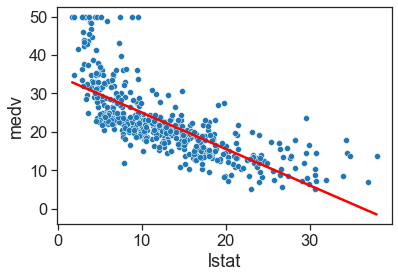

In [13]:
sns.scatterplot(x='lstat', y='medv', data=Boston)

X = pd.DataFrame({'lstat':[Boston.lstat.min(), Boston.lstat.max()]})
Y_pred = est.predict(X)
plt.plot(X, Y_pred, c='red')
plt.xlabel("lstat")
plt.ylabel("medv")

<AxesSubplot:xlabel='lstat', ylabel='medv'>

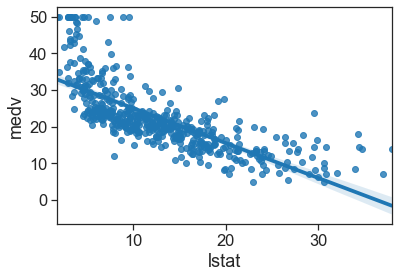

In [14]:
sns.regplot(x='lstat',y='medv', data=Boston)

Next we examine some diagnostic plots, several of which were discussed in Section 3.3.3. Four diagnostic plots are plotted according to the results from `ols()`. 

In [15]:
from statsmodels.stats.outliers_influence import OLSInfluence
infulence = OLSInfluence(est)

In [16]:
ols_sm_resid = est.resid # residuals
ols_fitted = est.fittedvalues
prstd = wls_prediction_std(est)[0]
ols_sm_resid_stud = ols_sm_resid / prstd # studentized residuals

In [17]:
ols_sm_resid_stud

0     -0.934757
1     -0.686184
2      0.637931
3      0.262993
4      1.077317
         ...   
501   -0.476760
502   -0.856021
503   -0.850307
504   -1.027468
505   -2.436677
Length: 506, dtype: float64

In [18]:
infulence.resid_studentized_internal

0     -0.938750
1     -0.687871
2      0.641041
3      0.264480
4      1.081699
         ...   
501   -0.477868
502   -0.858140
503   -0.853618
504   -1.031025
505   -2.443658
Length: 506, dtype: float64

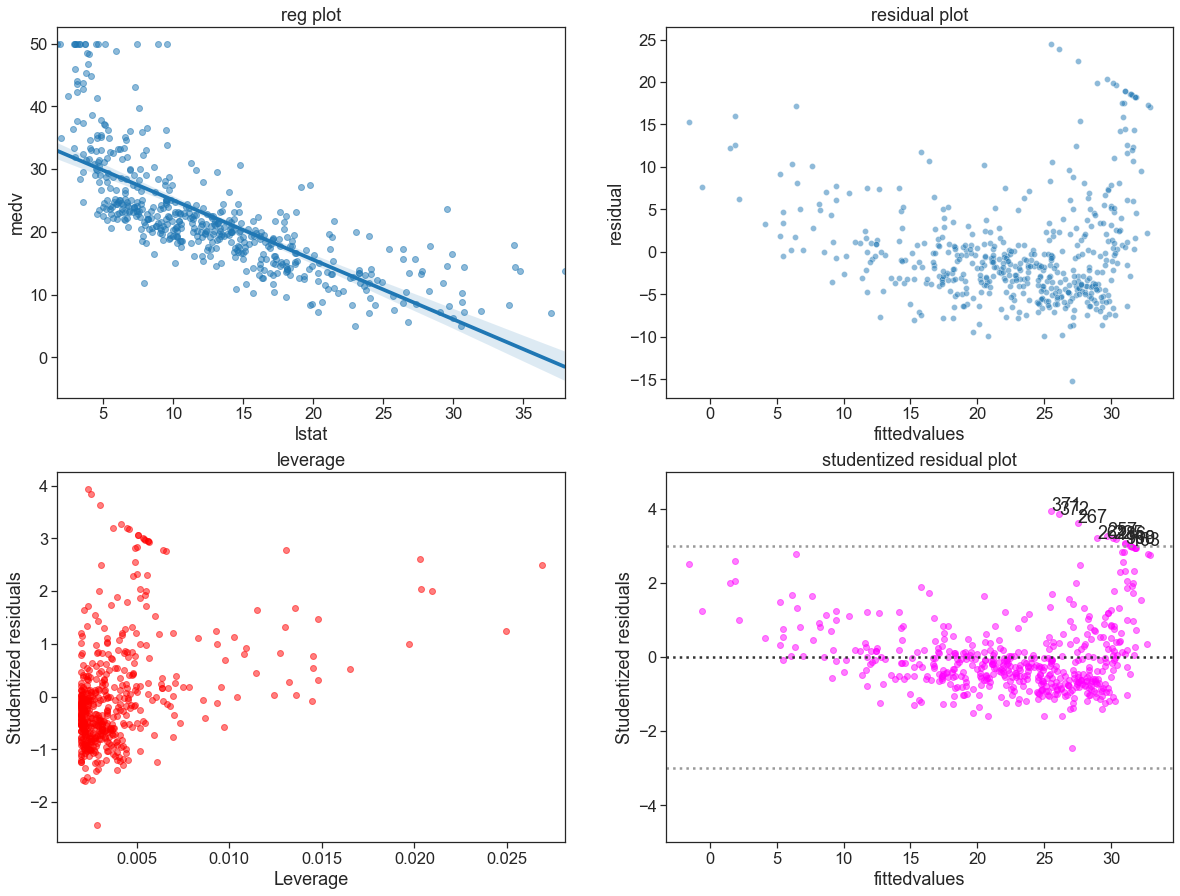

In [20]:
from statsmodels.graphics.regressionplots import *
from statsmodels.stats.outliers_influence import OLSInfluence


infulence = OLSInfluence(est)
ols_sm_resid = est.resid # residuals
ols_fitted = est.fittedvalues
ols_sm_resid_stud = infulence.resid_studentized_internal
leverage = OLSInfluence(est).hat_matrix_diag
#prstd = wls_prediction_std(est)[0]
#ols_sm_resid_stud = ols_sm_resid / prstd # studentized residuals

f, axes = plt.subplots(2, 2, sharex=False, sharey=False) 
f.set_figheight(15)
f.set_figwidth(20)

sns.regplot(x='lstat', y='medv', data=df, ax=axes[0, 0], scatter_kws={'alpha': 0.5}) # regression plot
axes[0, 0].set_title("reg plot")
sns.scatterplot(x=ols_fitted,y=ols_sm_resid, ax=axes[0, 1], alpha=0.5)
axes[0, 1].set_xlabel("fittedvalues")
axes[0, 1].set_ylabel("residual")
axes[0, 1].set_title("residual plot")
#sns.residplot(x=est.predict(), y='medv', data=df, ax=axes[0, 1], scatter_kws={'alpha': '0.5'}) # residual plot

#plot_leverage_resid2(ols_sm_results, ax=axes[1, 0], color='red') # leverage plot

# custom leverage plot instead of above
#axes[1, 0].autoscale(enable=True, axis='y', tight=True)
axes[1, 0].scatter(leverage, ols_sm_resid_stud, alpha=0.5, color='red')
axes[1, 0].set_xlabel("Leverage")
axes[1, 0].set_ylabel("Studentized residuals")
#axes[1, 0].set_ylim(-5, 5)
axes[1, 0].set_title("leverage")
# studentized residual plot
axes[1, 1].scatter(ols_fitted, ols_sm_resid_stud, alpha=0.5, color='magenta')
axes[1, 1].axhline(0, ls=":", c=".2")
axes[1, 1].axhline(-3, ls=":", c=".6")
axes[1, 1].axhline(3, ls=":", c=".6")
axes[1, 1].set_ylim(-5, 5)
axes[1, 1].set_xlabel("fittedvalues")
axes[1, 1].set_ylabel("Studentized residuals")
axes[1, 1].set_title("studentized residual plot")

x = est.fittedvalues[np.logical_or(ols_sm_resid_stud > 3, ols_sm_resid_stud < -3)]
y = ols_sm_resid_stud[np.logical_or(ols_sm_resid_stud > 3, ols_sm_resid_stud < -3)]

for i, x, y in zip(x.index, x, y):
    axes[1, 1].annotate(i, xy=(x, y));

# Multiple Regression

In order to fit a multiple linear regression model using least squares, we again use the `ols()` function. The syntax $ols(y \sim x1 + x2 + x3)$ is used to fit a model with three predictors, `x1`, `x2`, and `x3`. The `summary()` function now outputs the regression coefficients for all the predictors.

In [21]:
#string_cols = ' + '.join(data.columns[:-1])
est = smf.ols('medv ~ lstat+age',data = Boston).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Mon, 20 Sep 2021   Prob (F-statistic):           2.98e-88
Time:                        16:54:57   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.2228      0.731     45.458      0.0

The `Boston` data set contains 12 variables, and so it would be cumbersome to have to type all of these in order to perform a regression using all of the predictors.
Instead, we can use the code:

In [24]:
columns_selected = "+".join(Boston.columns.difference(["medv"]))
my_formula = "medv ~ " + columns_selected
est = smf.ols(my_formula,data = Boston).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     113.5
Date:                Mon, 20 Sep 2021   Prob (F-statistic):          2.23e-133
Time:                        16:55:33   Log-Likelihood:                -1504.9
No. Observations:                 506   AIC:                             3036.
Df Residuals:                     493   BIC:                             3091.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.6173      4.936      8.431      0.0

We can access the individual components of a summary object by name. Hence `est.rsquared` gives us the $R^2$, https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html. 

The `vif()` function, part of the `car` package, can be used to compute variance inflation factors.  Most VIF's are low to moderate for this data.

In [25]:
est.rsquared

0.7343070437613076

In [26]:
# don't forget to add constant if the ols model includes intercept
boston = Boston.drop('medv', axis=1).assign(const=1)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,const
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,1
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,1
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,1
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,1
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,1


In [27]:
# variance inflation factors
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

for i, col in enumerate(boston.columns):
    if col == 'const':
        pass
    elif len(col) > 6:
        print(col, ':', "{0:.2f}".format(vif(boston.to_numpy(), i)))
    else:
        print(col, '\t:', "{0:.2f}".format(vif(boston.to_numpy(), i)))

crim 	: 1.77
zn 	: 2.30
indus 	: 3.99
chas 	: 1.07
nox 	: 4.37
rm 	: 1.91
age 	: 3.09
dis 	: 3.95
rad 	: 7.45
tax 	: 9.00
ptratio : 1.80
lstat 	: 2.87


What if we would like to perform a regression using all of the variables but one?  For example, in the above regression output,  `age` has a high $p$-value. So we may wish to run a regression excluding this predictor. The following procedure results in a regression using all predictors except `age`.

In [28]:
columns_selected = "+".join(Boston.columns.difference(["medv", "age"]))
my_formula = "medv ~ " + columns_selected
lm_fit1 = smf.ols(formula = my_formula, data=Boston).fit()
lm_fit1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,41.5251,4.920,8.441,0.000,31.859,51.191
chas,2.8528,0.868,3.287,0.001,1.148,4.558
crim,-0.1214,0.033,-3.683,0.000,-0.186,-0.057
dis,-1.5068,0.193,-7.825,0.000,-1.885,-1.128
indus,0.0135,0.062,0.217,0.829,-0.109,0.135
lstat,-0.5474,0.048,-11.483,0.000,-0.641,-0.454
nox,-18.4851,3.714,-4.978,0.000,-25.782,-11.188
ptratio,-0.9346,0.132,-7.099,0.000,-1.193,-0.676
rad,0.2879,0.067,4.322,0.000,0.157,0.419
rm,3.6811,0.411,8.951,0.000,2.873,4.489


# Interaction term

It is easy to include interaction terms in a linear model using the `ols()` function. The syntax `lstat:age` tells `Python` to include an interaction term between `lstat` and `age`. The syntax `lstat * age` simultaneously includes `lstat`, `age`, and the interaction term `lstat`$\times$`age` as predictors; it is a shorthand for `lstat + age + lstat:age`.

In [29]:
est = smf.ols('medv ~ lstat*age',data = Boston).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Mon, 20 Sep 2021   Prob (F-statistic):           4.86e-88
Time:                        16:56:13   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.0885      1.470     24.553      0.0

## Non-linear Transformations of the Predictors

The `ols()` function can also accommodate non-linear transformations of the predictors. For instance, given a predictor $X$, we can create a predictor $X^2$ using  `I(X**2)`. The function `I()` is needed since the `**` has a special meaning in a formula object. We now perform a regression of `medv` onto `lstat` and `lstat^2`.

In [30]:
#adding power term
est = smf.ols('medv ~ lstat + I(lstat**2)',data = Boston).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Mon, 20 Sep 2021   Prob (F-statistic):          1.56e-112
Time:                        16:56:26   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        42.8620      0.872     49.149

The near-zero $p$-value associated with the quadratic term suggests that it leads to an improved model. We use the `anova()` function to further quantify the extent to which the quadratic fit is superior to the linear fit.

In [31]:
est2 = smf.ols('medv ~ lstat', data = Boston).fit()
sm.stats.anova_lm(est2, est, typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,504.0,19472.381418,0.0,NaN,NaN,NaN
1,503.0,15347.243158,1.0,4125.13826,135.199822,7.630116e-28


Here Model 0 represents the linear submodel containing only one predictor, `lstat`, while Model 1 corresponds to the larger quadratic model that has two predictors, `lstat` and `lstat^2`. The `anova()` function performs a hypothesis test
comparing the two models. The  null hypothesis is that the two models fit the data equally well,  and the alternative hypothesis is that the full model is superior. Here the $F$-statistic is $135$  and the associated $p$-value is virtually zero. This provides very clear evidence that the model containing the predictors `lstat` and `lstat^2` is far superior to the model that only contains the predictor `lstat`. This is not surprising, since earlier we saw evidence for non-linearity in the relationship between `medv` and `lstat`. If we type

In order to create a cubic fit, we can include a predictor of the form `I(X**3)`. However, this approach can start to get cumbersome for higher-order polynomials. A better approach involves using the `PolynomialFeatures()` function to create the polynomial within `ols()`. For example, the following command produces a fifth-order polynomial fit:

In [32]:
polynomial_features= PolynomialFeatures(degree=5) # using sklearn
xp = polynomial_features.fit_transform(Boston.lstat.values.reshape(-1,1))[:,1:] #the intercept should be removed first

In [33]:
ols_smf = smf.ols(formula='medv ~ xp', data=Boston)
ols_smf_results = ols_smf.fit()
print(ols_smf_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     214.2
Date:                Mon, 20 Sep 2021   Prob (F-statistic):          8.73e-122
Time:                        16:56:56   Log-Likelihood:                -1550.6
No. Observations:                 506   AIC:                             3113.
Df Residuals:                     500   BIC:                             3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     67.6997      3.604     18.783      0.0

This suggests that including additional  polynomial terms, up to fifth order, leads to an improvement in the model fit! However, further investigation of the data reveals that no polynomial terms beyond fifth order have significant $p$-values
in a regression fit.

Of course, we are in no way restricted to using polynomial transformations of the predictors. Here we try a log transformation.

In [34]:
# polynomial ols model with intercept
ols_smf = smf.ols(formula='medv ~ np.log(rm)', data=Boston)

# fitted model and summary
ols_smf_results = ols_smf.fit()
print(ols_smf_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     389.3
Date:                Mon, 20 Sep 2021   Prob (F-statistic):           1.22e-64
Time:                        16:57:02   Log-Likelihood:                -1695.4
No. Observations:                 506   AIC:                             3395.
Df Residuals:                     504   BIC:                             3403.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -76.4878      5.028    -15.213      0.0

# Qualitative predictors

We will now examine the `Carseats` data, which is part of the `ISLR2`. We will  attempt to predict `Sales`(child car seat sales) in $400$ locations based on a number of predictors.

In [36]:
Carseats = pd.read_csv("./Data/Carseats.csv")
print(Carseats.shape)
Carseats.head()

(400, 11)


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


The `Carseats` data includes qualitative predictors such as `shelveloc`, an indicator of the quality of the shelving location---that is, the  space within a store in which the car seat is displayed---at each location. The predictor `shelveloc` takes on three possible values:  *Bad*, *Medium*, and *Good*. Given a qualitative variable such as `shelveloc`, `Python` generates dummy variables automatically. Below we fit a multiple regression model that includes some interaction terms. The syntax `X1:XP` tells `Python` to include an interaction term between `X1` and `XP`.

In [37]:
# ols model with intercept
columns_selected = "+".join(Carseats.columns.difference(["Sales"]))
my_formula = "Sales ~ Income:Advertising + Price:Age + " + columns_selected  

# fitted model and summary
lm_fit = smf.ols(my_formula, data=Carseats).fit()
print(lm_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Mon, 20 Sep 2021   Prob (F-statistic):          6.14e-166
Time:                        16:57:33   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.5756    

`Python` has created a `ShelveLoc[T.Good]` dummy variable that takes on a value of 1 if the shelving location is good, and 0 otherwise. It has also created a `ShelveLoc[T.Medium]` dummy variable that equals 1 if the shelving location is medium, and 0 otherwise. A bad shelving location corresponds to a zero for each of the two dummy variables.
The fact that the coefficient for `ShelveLoc[T.Good]` in the regression output is positive indicates that a good shelving location is associated with high sales (relative to a bad location). And `ShelveLoc[T.Medium]` has a smaller positive coefficient, indicating that a medium shelving location is associated with higher sales than a bad shelving location but lower sales than a good shelving location.

### The sklearn is another popular way for performing OLS in Python

Check `sklearn`

In [38]:
from sklearn import linear_model

# ols model with intercept
ols_sl = linear_model.LinearRegression(fit_intercept=True) 

# fitted ols model (.values.reshape(-1, 1) is required for single predictor?)
x_train = Boston.lstat.values.reshape(-1, 1)
y_true =  Boston.medv
ols_sl.fit(x_train, y_true)

# summary
ols_sl.intercept_, ols_sl.coef_

(34.55384087938311, array([-0.95004935]))

In [39]:
y_pred = ols_sl.predict(Boston.lstat.values.reshape(-1, 1))
residual = y_true - y_pred

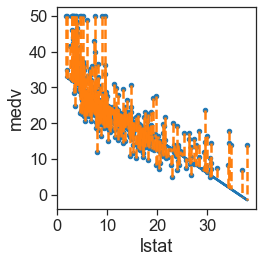

In [42]:
ax = Boston.plot.scatter(x='lstat', y='medv', figsize=(4, 4))
ax.plot(Boston.lstat, y_pred)
for x, yactual, yfitted in zip(Boston.lstat, Boston.medv, y_pred): 
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

In [43]:
# metrics
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

y_pred = ols_sl.predict(Boston.lstat.values.reshape(-1, 1))

ols_sl_summary = {'R2': r2_score(y_true, y_pred), 
                  'Ex. Var': explained_variance_score(y_true, y_pred), 
                  'MSE': mean_squared_error(y_true, y_pred)}

for k, v in ols_sl_summary.items():
    print(k, ':', v)

R2 : 0.5441462975864799
Ex. Var : 0.5441462975864798
MSE : 38.48296722989414


In [44]:
# out-of-sample predictions
ols_sl.predict(np.array([5, 10, 15]).reshape(-1, 1))

array([29.80359411, 25.05334734, 20.30310057])